<a href="https://colab.research.google.com/github/petersenmatthew/ai-skill-showcase/blob/feature%2Fmatthew/matthew_showcase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Matthew Petersen


---

Hey there! My name is Matthew Petersen and I am a 1A Systems Design Engineering student. I’m interested in joining WAT.ai because I am passionate about creating projects with real-world impact and using AI for meaningful research. SEE-DR is especially super interesting to me as I have actually worked on a project related to eye health screening in the past! I want to further develop my skills in AI/ML and contribute to making Waterloo known in the global AI technology field.

I have built a simple Convolutional Neural Network (CNN) from scratch to classify images of different sports balls. It consists of two convolutional layers w/ ReLU activation and max pooling. This is then followed by a fully connected layer and an output layer for classification.

The network learns to automatically extract features such as shapes and textures from raw images and predicts the correct category across 15 different sports balls. The final results are visualized by showing a batch of test images alongside the model’s predicted labels (w/ a confidence percentage).

In [29]:
# import libs
import os
import matplotlib.pyplot as plt
import numpy as np
import random
from google.colab import files
import zipfile
import kagglehub as kh
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# pytorch libs
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.nn.functional as F

## 1) Import data

 I used a large dataset from [Kaggle](https://www.kaggle.com/datasets/mdkabinhasan/sports-ball-dataset) to train + evaluate my model on 15 different sports balls.

In [30]:
# download dataset from kaggle
dataset_path = kh.dataset_download("mdkabinhasan/sports-ball-dataset")

# dataset root w/ class folders
dataset_root = os.path.join(dataset_path, "Sports-Ball-Dataset")

Using Colab cache for faster access to the 'sports-ball-dataset' dataset.


In [31]:
# check if GPU is available

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# 2) Transform + Split
Transform the images into 128x128 and split the kaggle dataset into 80% of images for training and 20% for testing.

In [32]:
data_path = os.path.join(dataset_path, "Sports-Ball-Dataset")

# Transform
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Full dataset
full_dataset = datasets.ImageFolder(root=data_path, transform=transform)

# Train/test split (80/20)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_data, test_data = random_split(full_dataset, [train_size, test_size])

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print(f"Train batches: {len(train_loader)}, Test batches: {len(test_loader)}")


Train batches: 67, Test batches: 17


# 3) CNN Design

Built a simple CNN with two convolutional + pooling layers to extract features.

In [33]:
# cnn design

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        # first convolutional layer - 3 input channels (RGB), 16 output channels
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2) # reduces spatial dimensions by a factor of 2
        # second convolutional layer - 16 input channels from previous layer, 32 output channels
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 32 * 32, 128)  # fully connected layer 1 - input features = 32*32*32
        self.fc2 = nn.Linear(128, num_classes)   # fully connected layer 2 - output = number of classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [B, 16, 64, 64]
        x = self.pool(F.relu(self.conv2(x)))  # [B, 32, 32, 32]
        x = x.view(x.size(0), -1)  # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN(num_classes=len(full_dataset.classes))
model = model.to(device)
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=32768, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [34]:
# define loss range and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 4) Train w/ Epochs

Trains the CNN model for a specified number of epochs (10 by default). Loops through the training data amd computing predictions + the loss. Backpropagation and updates the model weights using optimizer.

10 Epochs: ~ **43.55% Accuracy**

In [35]:
num_epochs = 10 # can be changed

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/10], Loss: 2.1804
Epoch [2/10], Loss: 1.7664
Epoch [3/10], Loss: 1.4540
Epoch [4/10], Loss: 1.1387
Epoch [5/10], Loss: 0.8454
Epoch [6/10], Loss: 0.5536
Epoch [7/10], Loss: 0.3615
Epoch [8/10], Loss: 0.2477
Epoch [9/10], Loss: 0.1581
Epoch [10/10], Loss: 0.1500


In [36]:
model.eval()  # evaluation mode
correct = 0
total = 0

with torch.no_grad():  # no gradients in testing
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 43.55%


# 5) Confusion Matrix

Evaluates the model on the test set and visualizes its predictions with a confusion matrix. Shows how often each class is correctly or incorrectly predicted, and what each ball is often confused with (if wrong).

<Figure size 1200x1200 with 0 Axes>

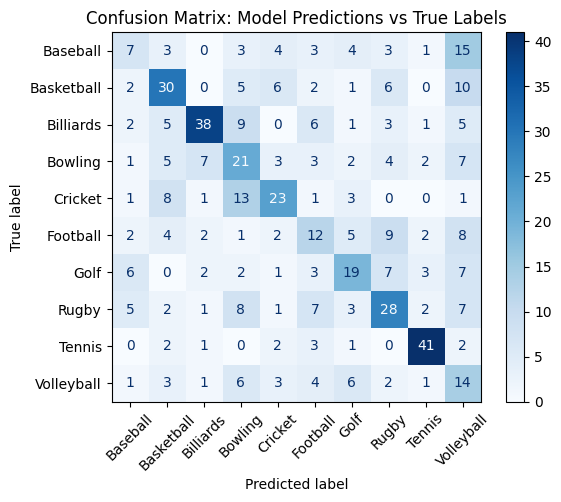

In [50]:

# put model in evaluation mode
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=full_dataset.classes)

# plot confusion matrix
plt.figure(figsize=(12,12))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix: Model Predictions vs True Labels")
plt.show()

# 5) Display Results

Display 6 random results w/ the true value vs. its prediction + confidence %

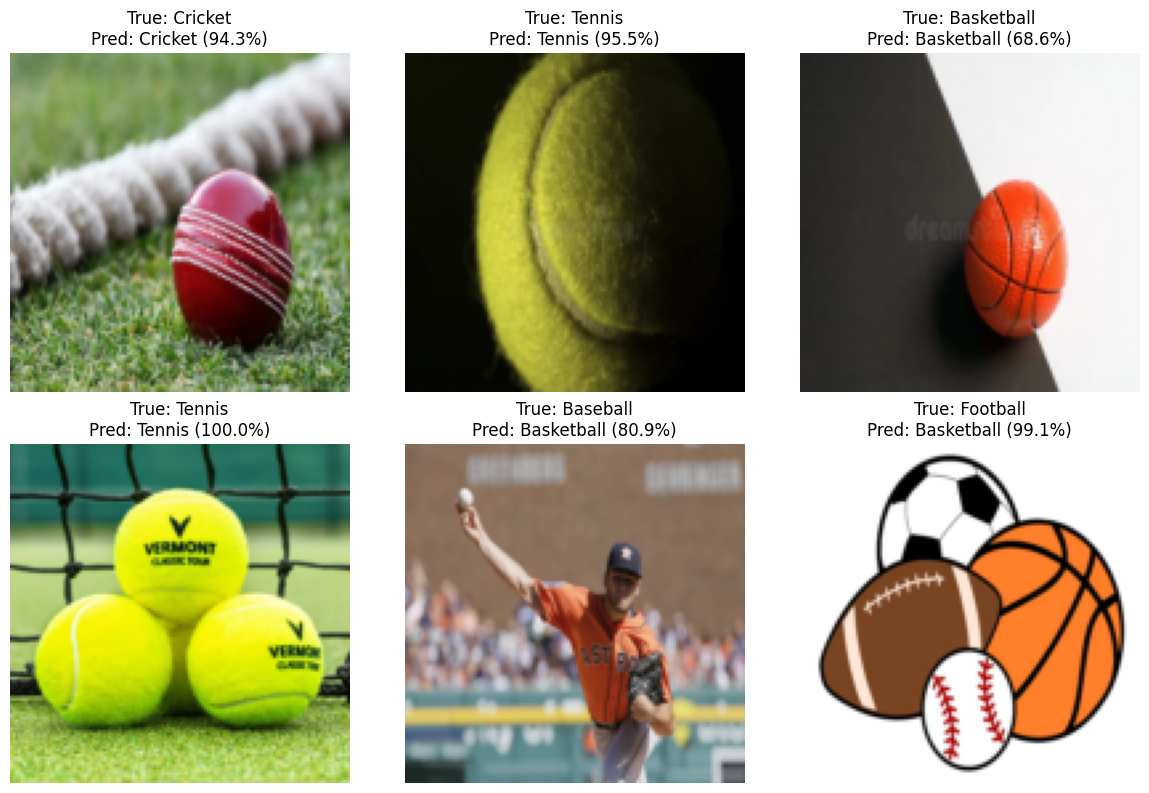

In [48]:
import random
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

# pick 6 random indices from the test dataset
num_images = 6
indices = random.sample(range(len(test_data)), num_images)

# grab the images and labels
images = torch.stack([test_data[i][0] for i in indices]).to(device)
labels = torch.tensor([test_data[i][1] for i in indices]).to(device)

#  model predictions and probabilities
model.eval()
with torch.no_grad():
    outputs = model(images)
    probs = F.softmax(outputs, dim=1)  # conv logits to probabilities
    _, preds = torch.max(outputs, 1)

# plot images with true labels, predicted labels, confidence
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    img = images[i].cpu().permute(1, 2, 0)  # conv from (C,H,W) to (H,W,C)
    ax.imshow(img)

    true_label = full_dataset.classes[labels[i]]  # true label
    pred_label = full_dataset.classes[preds[i]]  # predicted label
    confidence = probs[i][preds[i]].item() * 100       # confidence percentage

    ax.set_title(f"True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)")
    ax.axis("off")

plt.tight_layout()
plt.show()